# Summary

Explore derivation of geomorphic surface Lagrangian from the Hamiltonian, using various routes

### Logging

In [1]:
from importlib import reload
import logging, sys
reload(logging)
logging.basicConfig(level=logging.INFO, format=f'%(message)s')

### Modules

In [2]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['LagrangianExploration_sinbeta_eta1p5']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])
    
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import Matrix, Eq, lambdify, poly, \
    simplify, factor, expand, cancel, collect, expand_trig, \
    sin,cos,tan,sec, atan, Rational, sqrt, solve, Abs, N, re, im, \
    diff, pi, numer, denom
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Scipy utils
from scipy.optimize import root_scalar
from scipy.linalg import norm

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters
from gmplib.plot import GraphingBase

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.core.symbols import *
from gme.core.equations_extended import EquationsIdtxIbc, EquationsIbc

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme)
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Theory')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['LagrangianExploration_sinbeta_eta1p5'])

In [3]:
# # Import Sympy and Numpy and set up latex inline & pretty dict printing
# import sympy as sy, numpy as np, os
# sy.init_printing(pretty_print=True,wrap_line=True)
# from sympy import simplify, expand, factor, collect, \
#     Rational, Eq, solve, sqrt, cbrt, Matrix, diff, pi, \
#     poly, lambdify, N, numer, denom, trigsimp, Abs, \
#     sin, cos, tan, atan
# from scipy.optimize import root_scalar
# from scipy.linalg import norm

# # Import Geomorphysics library functions
# from gmplib.utils import e2d

# # Import GME classes and do a wildcard (!) import of all GME symbol definitions
# from gme.symbols import *
# from gme.equations import Equations

# from gmplib.plot_utils import GraphingBase

In [4]:
import matplotlib as mpl, matplotlib.pyplot as plt
mpl.rc('font', size=14, family='Arial')
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.ticker import MaxNLocator

### Parameter parsing

In [5]:
parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'Theory',
    'short_name': 'lagrangian_exploration',
    'subtitle': '',
    'title': 'Exploration of Lagrangian on-shell for sin(beta) erosion model, '
             'eta=3/2',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 3/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 3/4,
    't_xiv0_list': None,
    'varepsilon': 1/1000,
    'varepsilonhat': 1/100,
    'varphi_0': 300,
    'varphi_type': 'ramp',
    'x_1': 1,
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 30}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {   'Hamilton': 'DOP853',
                  'choices': ['RK45', 'RK23', 'Radau', 'DOP853', 'LSODA'],
                  'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn':

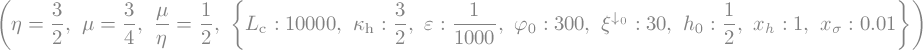

In [6]:
sub = {
        Lc: pr.model.Lc, 
        varepsilon: pr.model.varepsilon, 
        varphi_0: pr.model.varphi_0,
        xiv_0: pr.model.xiv_0,
        kappa_h: pr.model.kappa_h,
        h_0: pr.model.h_0,
        x_sigma: pr.model.x_sigma,
        x_h: pr.model.x_h
}
Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

In [7]:
# eta_ = Rational(1,2)
# sub = {
#         x_1: 1, 
#         varepsilon: Rational(1,1000), 
#         varphi_0: 300,
#         xiv_0: 30,
#         kappa_h: Rational(3,2),
#         h_0: Rational(1,2),
#         x_sigma: 0.01,
#         x_h: 1
# }
# Eq(eta,eta_), sub

# Basics

In [8]:
gmeq = EquationsIbc(eta_=pr.model.eta, 
                        mu_=pr.model.mu, 
                        beta_type=pr.model.beta_type, 
                        varphi_type=pr.model.varphi_type, 
                        ibc_type=pr.model.ibc_type,
                        parameters=sub,
                        do_raw=False)

core.equations.Equations
core.equations.EquationsMixedIn
core.equations.EquationsBase
core.rp.define_p_eqns
core.rp.define_r_eqns
core.xi.define_xi_eqns
core.xi.define_xi_model_eqn
core.xi.define_xi_related_eqns
core.varphi.define_varphi_model_eqns
core.varphi.define_varphi_related_eqns
core.fundamental.define_Fstar_eqns
core.fundamental.define_H_eqns
core.hamiltons.define_rdot_eqns
core.hamiltons.define_pdot_eqns
core.hamiltons.define_Hamiltons_eqns
core.ndim.nondimensionalize
core.ndim.define_nodimensionalized_Hamiltons_eqns
core.angles.define_tanalpha_eqns
core.angles.define_tanbeta_eqns
core.angles.define_psi_eqns
core.metrictensor.define_g_eqns
core.pxpoly.define_px_poly_eqn (ndim=False)
core.pxpoly.define_px_poly_eqn (ndim=True)
core.equations_extended.EquationsIbc
core.ibc.prep_ibc_eqns
core.ibc.define_ibc_eqns
core.ibc.set_ibc_eqns


In [9]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta'])
suffix = f'_eta{float(sy.N(gmeq.eta_))}'
job_name = prefix+suffix.replace('.','p')
job_name

'lagrangian_exploration_sinbeta_eta1p5'

In [10]:
# gr = GraphingBase()

# Recap of Hamiltonian, front and ray angles

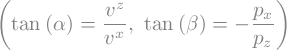

In [11]:
gmeq.tanalpha_rdot_eqn, gmeq.tanbeta_pxpz_eqn

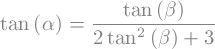

In [12]:
gmeq.tanalpha_beta_eqn

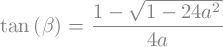

In [13]:
tanbeta_eqn = gmeq.tanbeta_alpha_eqns[0].subs({tan(alpha):ta})
tanbeta_eqn

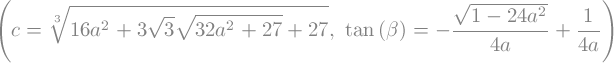

In [14]:
c_a_eqn = Eq(c,((16*ta**2+3*sqrt(3)*sqrt((32*ta**2+27))+27)**Rational(1,3)) )
tanbeta_c_a_eqn = Eq(tanbeta_eqn.lhs, expand(tanbeta_eqn.rhs.subs({c_a_eqn.rhs:c})) )
c_a_eqn, tanbeta_c_a_eqn

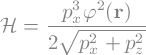

In [15]:
gmeq.H_eqn

# Find an on-shell point in T*M

To test our derivations, at minimum we need a point in slowness phase space that is on-shell, along with its counterpart in velocity phase space. We start with setting some model constants.

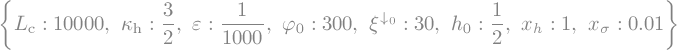

In [16]:
sub

Let's arbitrarily choose $x=0$, as if we were choosing a viable boundary condition. We first need the erosion rate $\xi(0)$:

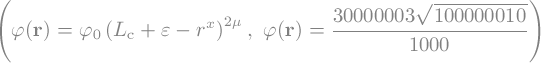

In [17]:
varphi_ = gmeq.varphi_rx_eqn.rhs.subs(sub).subs({rx:0}).subs({mu:pr.model.mu})
gmeq.varphi_rx_eqn, Eq(varphi_rx(rvec).subs({rx:0}),varphi_)

From the erosion model, derive an equation in terms of $p_x$, $u^\downarrow$ and $\xi$ only:

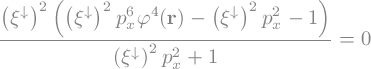

In [18]:
# gmeq.px_pz_xi_varphi_eqn
gmeq.px_xiv_varphi_eqn

In [19]:
# px_varphi_xiv_eqn = simplify( Eq( gmeq.xiv_varphi_pxpz_eqn.lhs**2/xiv**2,
#                                     gmeq.xiv_varphi_pxpz_eqn.rhs**2/xiv**2) )
# expand(px_varphi_xiv_eqn), expand(px_varphi_xiv_eqn).subs({varphi_r:varphi_})

and convert into a polynomial in $p_x$ for the chosen point:

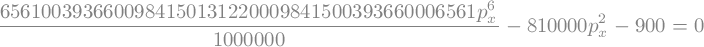

In [20]:
px_eqn = Eq(numer(gmeq.px_xiv_varphi_eqn.lhs
                       .subs({varphi_r(rvec):varphi_})
                       .subs({xiv:xiv_0})
                       .subs(sub)),0)
px_eqn

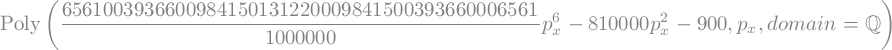

In [21]:
px0_poly_eqn = poly(px_eqn)
px0_poly_eqn

Find the value of $p_x$ at this point $x=0$:

In [22]:
px0_poly_lambda = lambdify( [px], px0_poly_eqn.as_expr() )
dpx0_poly_lambda = lambdify( [px], diff(px0_poly_eqn.as_expr(),px) )
px0_root_search = root_scalar( px0_poly_lambda, fprime=dpx0_poly_lambda,
                               method='newton', x0=0.01 )
px_ = px0_root_search.root
pz_ = -1/xiv_0.subs(sub)
Eq((px,pz),(px_,sy.N(pz_)))

and use Hamilton's equations to find the ray velocity $\mathbf{v}=\mathbf{\dot{r}}$:

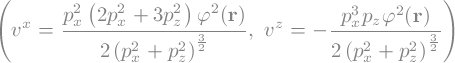

In [23]:
gmeq.rdotx_pxpz_eqn, gmeq.rdotz_pxpz_eqn

In [24]:
gmeq.rdotx_pxpz_eqn.subs({px:px_,pz:pz_}), gmeq.rdotz_pxpz_eqn.subs({px:px_,pz:pz_})

In [25]:
vx_ = gmeq.rdotx_pxpz_eqn.rhs.subs({varphi_r:varphi_, px:px_, pz:pz_})
vz_ = gmeq.rdotz_pxpz_eqn.rhs.subs({varphi_r:varphi_, px:px_, pz:pz_})
Eq(rdotx,vx_), Eq(rdotz,vz_)

and compute the corresponding surface tilt $\beta$ and ray angle $\alpha$:

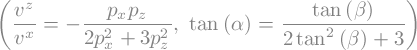

In [26]:
(gmeq.rdotz_on_rdotx_eqn, gmeq.tanalpha_beta_eqn)

In [27]:
gmeq.tanalpha_rdot_eqn.subs({rdotx:vx_, rdotz:vz_})

In [28]:
tanbeta_ = gmeq.tanbeta_pxpz_eqn.rhs.subs({px:px_,pz:pz_})
# tanalpha_ = gmeq.tanalpha_pxpz_eqn.rhs.subs({px:px_,pz:pz_})
tanalpha_ = gmeq.tanalpha_beta_eqn.rhs.subs({tan(beta):tanbeta_})
Eq(tan(beta),tanbeta_), Eq(tan(alpha),tanalpha_)

In [29]:
Eq(beta,N(atan(tanbeta_)*180/pi)), Eq(alpha,N(atan(tanalpha_)*180/pi))

# Lagrangian on-shell $L=\frac{1}{2}F^2$  via Legendre transform

Recall the Hamiltonian:

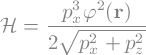

In [30]:
gmeq.H_eqn

and perform the Legendre transform to get the Lagrangian, albeit in T*M coordinates:

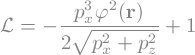

In [31]:
L_eqn = simplify(expand((Eq(L, 1-H).subs({H: gmeq.H_eqn.rhs}))))
L_eqn

Recall the ray velocity vector components obtained from Hamilton's equations:

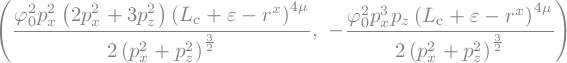

In [32]:
gmeq.hamiltons_eqns[0], gmeq.hamiltons_eqns[1]

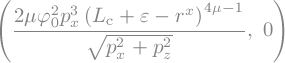

In [33]:
gmeq.hamiltons_eqns[2], gmeq.hamiltons_eqns[3]

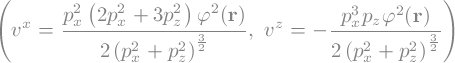

In [34]:
vx_eqn = factor(gmeq.rdotx_pxpz_eqn)
vz_eqn = gmeq.rdotz_pxpz_eqn
vx_eqn, vz_eqn

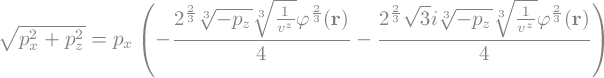

In [35]:
p_px_pz_vz_eqn = Eq(sqrt(px**2+pz**2), solve(vz_eqn, sqrt(px**2+pz**2))[0])
p_px_pz_vz_eqn

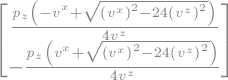

In [36]:
Matrix( solve(vx_eqn.subs(e2d(p_px_pz_vz_eqn)),px) )

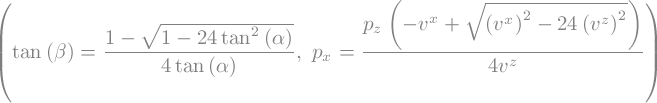

In [37]:
px_pz_vx_vz_eqn = Eq(px, solve( gmeq.tanbeta_alpha_eqns[0]
                            .subs(e2d(gmeq.tanalpha_rdot_eqn))
                            .subs(e2d(gmeq.tanbeta_pxpz_eqn)), px)[0])
gmeq.tanbeta_alpha_eqns[0], px_pz_vx_vz_eqn

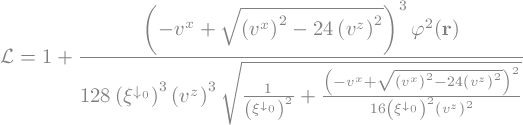

In [38]:
L_simple_eqn = (
    L_eqn.subs(e2d(px_pz_vx_vz_eqn)).subs({pz:pz_0}).subs(e2d(gmeq.pz0_xiv0_eqn))
)
L_simple_eqn

In [39]:
N(L_simple_eqn.subs({tan(beta):tanbeta_, rdotx:vx_, 
                rdotz:vz_, xiv:xiv_0, varphi_r:varphi_}).subs(sub))

# Lagrangian on-shell $L=\frac{1}{2}F^2$ from metric tensor

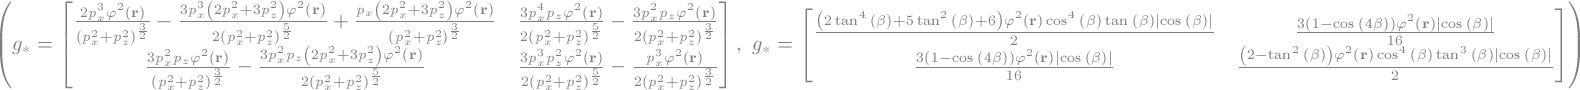

In [40]:
gstar_tanbeta_eqn = simplify( gmeq.gstar_varphi_pxpz_eqn
                             .subs({gmeq.px_pz_tanbeta_eqn.lhs:gmeq.px_pz_tanbeta_eqn.rhs}) )
gmeq.gstar_varphi_pxpz_eqn, gstar_tanbeta_eqn

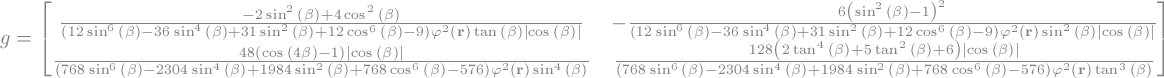

In [41]:
g_xi_tanbeta_eqn = Eq(g, simplify(gstar_tanbeta_eqn.rhs.inverse()))
g_xi_tanbeta_eqn

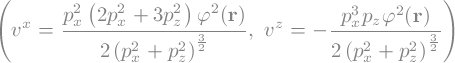

In [42]:
factor(gmeq.rdotx_pxpz_eqn), gmeq.rdotz_pxpz_eqn

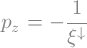

In [43]:
gmeq.pz_xiv_eqn

The following equation ONLY works along geodesics, i.e., ray trajectories.

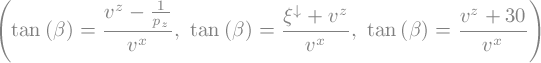

In [44]:
# tanbeta_rdotxz_pz_eqn = Eq(tan(beta), (rdotz - 1/pz)/rdotx )
# tanbeta_rdotxz_xiv_eqn = tanbeta_rdotxz_pz_eqn.subs({pz:pz_xiv_eqn.rhs})
( gmeq.tanbeta_rdotxz_pz_eqn, gmeq.tanbeta_rdotxz_xiv_eqn, 
  gmeq.tanbeta_rdotxz_xiv_eqn.subs({xiv:xiv_0}).subs(sub) )

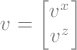

In [45]:
rdot_def_eqn = Eq(rdot_vec, Matrix([rdotx, rdotz]))
rdot_def_eqn

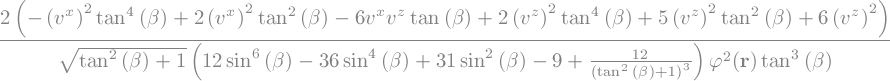

In [46]:
simplify( (rdot_def_eqn.rhs.T*(g_xi_tanbeta_eqn.rhs * rdot_def_eqn.rhs))[0]
     .subs({Abs(cos(beta)):cos(beta)})
     .subs({sin(beta):tan(beta)*cos(beta)})
     .subs({cos(beta):1/sqrt(1+tan(beta)**2)})
).subs({cos(beta):1/sqrt(1+tan(beta)**2)})

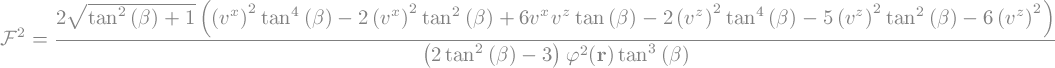

In [47]:
Fsqrd_rdotxz_tanbeta_eqn = Eq(F**2,
    factor(simplify( (rdot_def_eqn.rhs.T*(g_xi_tanbeta_eqn.rhs * rdot_def_eqn.rhs))[0]
         .subs({Abs(cos(beta)):cos(beta)})
         .subs({sin(beta):tan(beta)*cos(beta)})
         .subs({cos(beta):1/sqrt(1+tan(beta)**2)})
    ).subs({sin(beta):sqrt(1-cos(beta)**2)}).subs({cos(beta):1/sqrt(1+tan(beta)**2)}))
                             )
Fsqrd_rdotxz_tanbeta_eqn

In [48]:
(numer(Fsqrd_rdotxz_tanbeta_eqn.rhs).subs({tan(beta):tanbeta_,rdotz:vz_,rdotx:vx_}),
 denom(Fsqrd_rdotxz_tanbeta_eqn.rhs).subs({tan(beta):tanbeta_,rdotz:vz_,rdotx:vx_}))

In [49]:
Fsqrd_rdotxz_tanbeta_eqn.subs({tan(beta):tanbeta_, 
                    rdotx:vx_, rdotz:vz_, varphi_r:varphi_}).subs(sub)

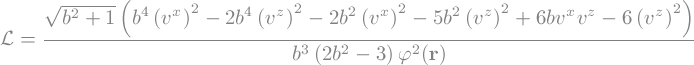

In [50]:
Eq(L, (Fsqrd_rdotxz_tanbeta_eqn.subs({tan(beta):tb}).rhs/2) )

In [51]:
float(sy.deg(atan(sqrt(pr.model.eta))))

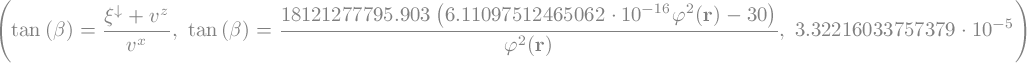

In [52]:
gmeq.tanbeta_rdotxz_xiv_eqn, gmeq.tanbeta_rdotxz_xiv_eqn \
                                .subs({xiv:-xiv_0, rdotx:vx_, rdotz:vz_}) \
                                .subs(sub), tanbeta_

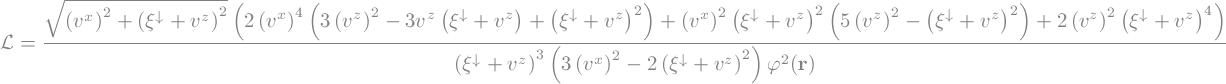

In [53]:
L_rdotxz_xiv_eqn = Eq( L, (simplify( (Fsqrd_rdotxz_tanbeta_eqn.rhs/2)
                                  .subs({tan(beta):gmeq.tanbeta_rdotxz_xiv_eqn.rhs}))) )
L_rdotxz_xiv_eqn

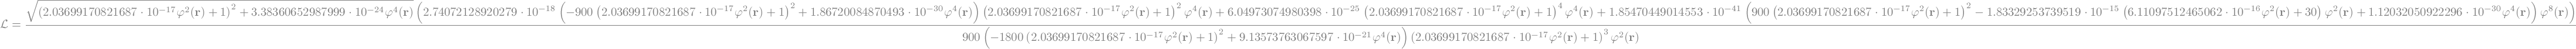

In [54]:
L_rdotxz_xiv_eqn.subs({tan(beta):tanbeta_, 
                       rdotx:vx_, rdotz:vz_, xiv:xiv_0, varphi_r:varphi_}).subs(sub)

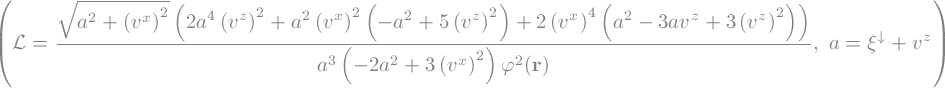

In [55]:
(L_rdotxz_xiv_eqn.subs({xiv+rdotz:ta})), Eq( ta, xiv+rdotz )

# $F$ check

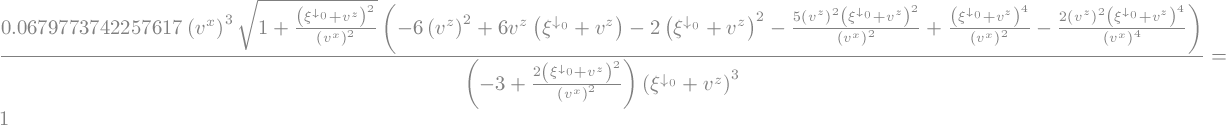

In [56]:
F_parametric_eqn = Eq(((Fsqrd_rdotxz_tanbeta_eqn.rhs)
                       .subs(e2d(gmeq.tanbeta_rdotxz_xiv_eqn))
                       .subs({varphi_r(rvec):5.42416391692687, xiv:xiv_0})),1)
F_parametric_eqn

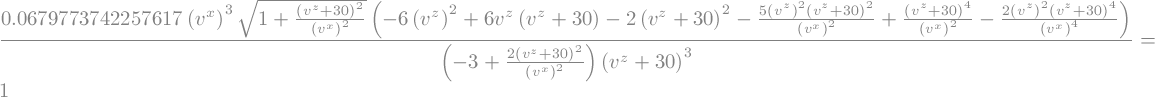

In [57]:
F_parametric_eqn_ = F_parametric_eqn.subs({xiv_0:30})
F_parametric_eqn_

In [58]:
vz_array = np.linspace(0.0001, 8, 100)
vx_poly_eqn = sy.poly(F_parametric_eqn_)
vx_poly_lambda = lambdify( [rdotx,rdotz], vx_poly_eqn.as_expr() )
dvx_poly_lambda = lambdify( [rdotx,rdotz], diff(vx_poly_eqn.as_expr(),rdotx) )

vx_solutions = lambda vx_guess_: np.array([
    (root_scalar( vx_poly_lambda, args=(vz_),fprime=dvx_poly_lambda, 
                 method='newton', x0=vx_guess_ )).root for vz_ in vz_array])
vx_array = vx_solutions(10)

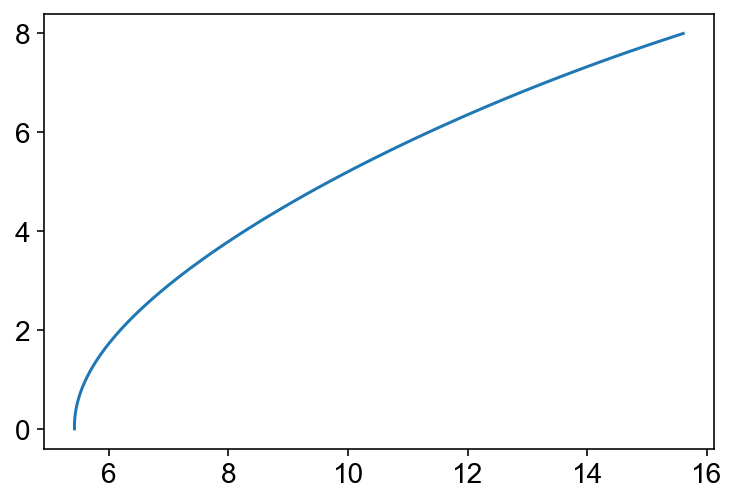

In [59]:
from matplotlib import pyplot as plt
plt.plot(vx_array,vz_array)
# plt.ylim(0,)
# plt.xlim(0,max(vx_array)*1.02);
# plt.plot(5.64880183960402,1.03775116238436, 'o')
axes = plt.gca()
# axes.set_aspect(1)

# Save

In [60]:
# plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
# export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )